## First pratical of the Unsupervised Language Learning course 2017-2018

Joris Mollinga: 11871431 

Aron Hammond: 10437215

In [48]:
import numpy as np
import os
import sklearn
import pprint
from collections import deque
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from scipy.stats import pearsonr 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import random

In [49]:
def cosine_sim(a,b):
    t = np.dot(a,b)
    n = np.linalg.norm(a) * np.linalg.norm(b)
    return t/n

In [50]:
# Read the word embeddings file
def readWORDSfile(fileName):
    word2vec = {}
    
    w2i = {}
    i2w = {}

    with open (fileName,'r',encoding="utf8") as emb:
        i = 0
        for line in emb:
            row = line.split()
            word = row[0]
            embedding = row[1:]

            # Convert to floats and assign in dictionary
            word2vec[word] = [float(i) for i in embedding] 
            
            i2w[i] = word
            w2i[word] = i
            i += 1
    return word2vec,i2w,w2i

def read2000words(fileName):
        
    with open (fileName,'r') as nouns:
        words = nouns.readlines()
        
    words = [i.split()[0] for i in words]
            
    return words

def readMEN(fileName):
    judgements = []
    
    with open (fileName,'r') as file:
        for line in file:
            judgements.append(line.split())
    
    return judgements

def readSimLex(fileName):
    judgements = []
    
    with open (fileName,'r') as file:
        for i, line in enumerate(file):
            if i == 0: continue
            judgement = line.split('\t')
            judgements.append([judgement[0], judgement[1], judgement[3]])
            
    return judgements

In [8]:
word2vec, W2V_i2w, W2V_w2i = readWORDSfile('deps.WORDS')

In [9]:
bow2, bow2_i2w, bow2_w2i = readWORDSfile('bow2.WORDS')

In [10]:
bow5, bow5_i2w, bow5_w2i = readWORDSfile('bow5.WORDS')

In [ ]:
men = readMEN(os.path.join('MEN', 'MEN_dataset_natural_form_full'))

In [ ]:
simlex = readSimLex(os.path.join('SimLex-999', 'SimLex-999.txt'))

In [51]:
words = read2000words('2000_nouns_sorted.txt')
w2v_nouns = []
bow2_nouns = []
bow5_nouns = []
removeList = []

for word in words:
    try:
        w2v_nouns.append(word2vec[word])
        bow2_nouns.append(bow2[word])
        bow5_nouns.append(bow5[word])
    except:
        removeList.append(word)

for word in removeList:
    words.remove(word)

In [13]:
def find_closest_word(a,p,i2w,n=1):
    if n == 1:
        sim = [cosine_sim(p[i],a) for i in range(0,len(p))]
        idx = sim.index(max(sim))
        return i2w[idx]
    else:
        sim = [cosine_sim(p[i],a) for i in range(0,len(p))]
        idx = sorted(range(len(sim)), key=lambda i: sim[i])[-n:]
        return list(reversed([i2w[i] for i in idx]))

## Word Similarity

In [ ]:
def similarity(word1, word2, model):
    '''Compute the cosine similarity of the embeddings of word1 and word2 under the supplied model'''
    
    if not word1 in model or not word2 in model:
        return 0
    
    emb1 = model[word1]
    emb2 = model[word2]
    
    unit_emb1 = emb1 / np.linalg.norm(emb1)
    unit_emb2 = emb2 / np.linalg.norm(emb2)
    
    return np.dot(unit_emb1, unit_emb2)

def evaluate_models_on_set(judgements):
    result = []
    used = []
    
    for pair in judgements:
        word1, word2, score = pair
        bow2sim = similarity(word1, word2, bow2)
        bow5sim = similarity(word1, word2, bow5)
        depssim = similarity(word1, word2, word2vec)
        
        row = [bow2sim, bow5sim, depssim]
        
        if not all(row):
            continue
        
        result.append(row)
        used.append(pair)
    
    return np.array(result, dtype=np.float64), used

def pearson(results, scores):
    corr = []
    for i in range(np.size(results, 1)):
        corr.append(pearsonr(results[:,i], scores)[0])
        
    return np.array(corr)

def top5_similar(model, word):
    top5 = deque()
    
    if word in model:
        emb = model[word]
    
    

# Compute cosine similarity between the words using the three models
# words that don't occur in the models are skipped and removed from
# the evaluation set.
MENResults, men = evaluate_models_on_set(men)
SimLexResults, simlex = evaluate_models_on_set(simlex)
    
# Evaluate the model-produced similarities against human judgements in terms of 
# Pearson and Spearman correlation coefficients.

# Collect human judgements (last column of dataset)
MENScores = np.array([judgement[-1] for judgement in men], dtype=np.float64)
SimLexScores = np.array([judgement[-1] for judgement in simlex], dtype=np.float64)

correlations = {"MEN" : {
                   "Spearman" : [],
                   "Pearson" : []},
               "SimLex" : {
                   "Spearman" : [],
                   "Pearson" : []
               }}

correlations["MEN"]["Spearman"] = spearmanr(MENResults, MENScores, axis = 0).correlation[0:3,-1]
correlations["MEN"]["Pearson"] = pearson(MENResults, MENScores)
correlations["SimLex"]["Spearman"] = spearmanr(SimLexResults, SimLexScores, axis = 0).correlation[0:3,-1]
correlations["SimLex"]["Pearson"] = pearson(SimLexResults, SimLexScores)

pprint.pprint(correlations)

# Compare the performance of the three models on this task.

#  Analyze the data qualitatively and report what are the differences in the kind
# of similarity captured by the three models.

Looking at both Pearson and Spearman correlations, the similarity scores for \texttt{bow5} seem to correlate the best with the MEN evaluations but worst with SimLex. This is most likeley due to the fact that SimLex focusses on similarity rather than relatedness and a larger window captures relatively more topical relations. As expected, the dependency based embeddings have the highest correlation on SimLex.
What is curious, is that correlations with MEN are striclty larger than those on SimLex. 

## Word Analogy

## Clustering

In [52]:
pca2 = PCA(n_components=2)
Xw2v = pca2.fit_transform(list(word2vec.values()))
Xbow2 = pca2.fit_transform(list(bow2.values()))
Xbow5 = pca2.fit_transform(list(bow5.values()))

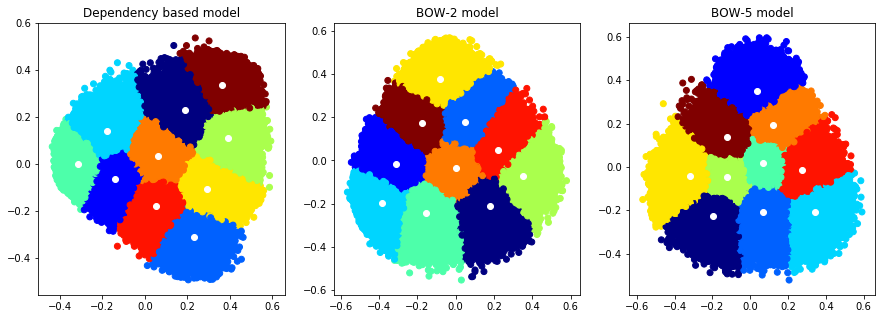

In [53]:
num_clusters = 10
kmeans_w2v = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xw2v)
predict_w2v = kmeans_w2v.predict(Xw2v)
centers_w2v = kmeans_w2v.cluster_centers_

kmeans_bow2 = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xbow2)
predict_bow2 = kmeans_bow2.predict(Xbow2)
centers_bow2 = kmeans_bow2.cluster_centers_

kmeans_bow5 = KMeans(n_clusters = num_clusters,random_state = 0).fit(Xbow5)
predict_bow5 = kmeans_bow5.predict(Xbow5)
centers_bow5 = kmeans_bow5.cluster_centers_

f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
ax1.scatter(Xw2v[:,0],Xw2v[:,1], c=predict_w2v,cmap= 'jet')
ax1.scatter(centers_w2v[:,0],centers_w2v[:,1],c='1.0')
ax1.set_title('Dependency based model')

ax2.scatter(Xbow2[:,0],Xbow2[:,1], c=predict_bow2,cmap= 'jet')
ax2.scatter(centers_bow2[:,0],centers_bow2[:,1],c='1.0')
ax2.set_title('BOW-2 model')

ax3.scatter(Xbow5[:,0],Xbow5[:,1], c=predict_bow5,cmap= 'jet')
ax3.scatter(centers_bow5[:,0],centers_bow5[:,1],c='1.0')
ax3.set_title('BOW-5 model')
plt.show()

In [ ]:
num_clusters = 200
kmeans_w2v_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(w2v_nouns)
centers_w2v_nouns = kmeans_w2v_nouns.cluster_centers_
predict_w2v_nouns = kmeans_w2v_nouns.predict(w2v_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_w2v_nouns) == len(words)

for cluster,word in zip(predict_w2v_nouns,words):
    word_list[cluster].append(word)
    
''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  

In [ ]:
num_clusters = 200
kmeans_bow2_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(bow2_nouns)
centers_bow2_nouns = kmeans_bow2_nouns.cluster_centers_
predict_bow2_nouns = kmeans_bow2_nouns.predict(bow2_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_bow2_nouns) == len(words)

for cluster,word in zip(predict_bow2_nouns,words):
    word_list[cluster].append(word)
    
''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  

In [ ]:
num_clusters = 200
kmeans_bow5_nouns = KMeans(n_clusters = num_clusters,random_state = 0).fit(bow5_nouns)
centers_bow5_nouns = kmeans_bow5_nouns.cluster_centers_
predict_bow5_nouns = kmeans_bow5_nouns.predict(bow5_nouns)

word_list = [[] for x in range(num_clusters)]
assert len(predict_bow5_nouns) == len(words)

for cluster,word in zip(predict_bow5_nouns,words):
    word_list[cluster].append(word)

''' 
print_all_clusters = False
if print_all_clusters:
    for cluster in word_list:
        print (cluster)
        print ('')
else:
    samples = random.sample(word_list,10)
    for sample in samples:
        print (sample)
        print ('')
'''        
for cluster in word_list:
    if 'money' in cluster:
        print (cluster)
    elif 'italy' in cluster:
        print (cluster)
    elif 'scientist' in cluster:
        print (cluster)  